In [1]:
import numpy as np
from glob import glob
from collections import Counter, namedtuple, defaultdict, ChainMap
from operator import attrgetter
import heapq
import pysam
import pandas as pd
import joblib
from matplotlib import pyplot as plt

In [2]:
import matplotlib.ticker as ticker

# 设置全局字体

import matplotlib.font_manager as font_manager
font_dirs = ["/public/home/mowp/test/fonts/"]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
    
plt.rcParams["font.family"] = "Arial"
plt.rcParams['font.size'] = 12
plt.rcParams['svg.fonttype'] = 'none'

In [3]:
# parse bam file
def bam_cigar_to_invs(aln, max_allowed_insertion):
    invs = []
    start = aln.reference_start
    end = aln.reference_end
    strand = '-' if aln.is_reverse else '+'
    left = start
    right = left
    has_ins = False
    for op, ln in aln.cigartuples:
        if op in (4, 5):
            # cigartuples: 
            #   S  BAM_CSOFT_CLIP  4
            #   H  BAM_CHARD_CLIP  5
            # does not consume reference
            continue
        elif op == 1 and ln > max_allowed_insertion:
            # cigartuples: 
            #   I  BAM_CINS  1
            has_ins = True
        elif op in (0, 2, 7, 8):
            # cigartuples: 
            #   M  BAM_CMATCH  0
            #   D  BAM_CDEL  2
            #   =  BAM_CEQUAL  7
            #   X  BAM_CDIFF  8
            # consume reference but do not add to invs yet
            right += ln
        elif op == 3:
            # cigartuples: 
            #   N  BAM_CREF_SKIP  3
            invs.append([left, right])
            left = right + ln
            right = left

        # ❗ 以下if语句应该在循环内
        if right > left:
            invs.append([left, right])
    assert invs[0][0] == start
    assert invs[-1][1] == end
    return start, end, strand, np.array(invs), has_ins

PARSED_ALN = namedtuple('Aln', 'chrom start end read_id strand invs')

def parse_pysam_aln(aln, max_allowed_insertion):
    chrom = aln.reference_name
    read_id = aln.query_name
    start, end, strand, invs, has_ins = bam_cigar_to_invs(
        aln, max_allowed_insertion)
    return PARSED_ALN(chrom, start, end, read_id, strand, invs), has_ins

In [4]:
# parse bed file

def parse_exons_introns_flank(record, flanksize=200):
    start = int(record[1])
    end = int(record[2])
    exstarts = np.fromstring(record[11], sep=',') + start
    exends = exstarts + np.fromstring(record[10], sep=',')
    exons = np.dstack([exstarts, exends])[0]
    left_flank = np.array([[max(0, start - flanksize), start]])
    right_flank = np.array([[end, end + flanksize]])
    if len(exons) > 1:
        introns = np.dstack([exons[:-1, 1], exons[1:, 0]])[0]
    else:
        introns = np.array([])
    return exons, introns, left_flank, right_flank


def split_intervals(invs, pos, side='left'):
    idx = np.searchsorted(invs.ravel(), pos)
    split = np.insert(invs.ravel(), idx, [pos, pos]).reshape(-1, 2)
    split_idx = (idx + 1) // 2
    return split[:split_idx], split[split_idx:]


def parse_cds_utr_introns_flank(record, flanksize):
    exons, introns, left_flank, right_flank = parse_exons_introns_flank(record, flanksize)
    cds_start = int(record[6])
    cds_end = int(record[7])
    if not cds_start == cds_end:
        utr1, cds = split_intervals(exons, cds_start)
        cds, utr2 = split_intervals(cds, cds_end)
    else:
        utr1 = np.array([])
        cds = np.array([])
        utr2 = np.array([])
    return utr1, cds, utr2, introns, left_flank, right_flank, exons


def parse_features(record, flanksize=500):
    ''' 
    Parse bed format

    flanksize: up/downstream distance

    Return:
        {'chrom': '1',
        'strand': '+',
        'gene_id': 'spliced_9162',
        'invs': {
                'cds': np.array([[],]),
                'introns': np.array([[],]),
                'exons': np.array([[],]),
                '5utr': array([[]], shape=(0, 2), dtype=float64),
                '3utr': array([[]]),
                'upstream': array([[]]),
                'downstream': array([[]])
                }
        }
    '''
    features = {}
    invs = {}
    features['chrom'] = record[0].replace('Chr', '')
    features['strand'] = record[5]
    features['gene_id'] = record[3]
    utr1, invs['cds'], utr2, invs['introns'], left_flank, right_flank, invs['exons'] = parse_cds_utr_introns_flank(record, flanksize)
    if features['strand'] == '+':
        invs['5utr'] = utr1
        invs['3utr'] = utr2
        invs['upstream'] = left_flank
        invs['downstream'] = right_flank
    else:
        invs['5utr'] = utr2
        invs['3utr'] = utr1
        invs['upstream'] = right_flank
        invs['downstream'] = left_flank
    features['invs'] = invs
    return features

In [5]:
# intersect spliced invs
def intersect(inv_a, inv_b):
    a_start, a_end = inv_a
    b_start, b_end = inv_b
    if a_end < b_start or a_start > b_end:
        return 0
    else:
        s = max(a_start, b_start)
        e = min(a_end, b_end)
        return e - s
    

def intersect_spliced_invs(invs_a, invs_b):
    '''
    Input:
        invs_a: bam invs
        invs_b: bed invs

    Return:
        overlap bases between invs
    '''
    score = 0
    invs_a = iter(invs_a)
    invs_b = iter(invs_b)
    a_start, a_end = next(invs_a)
    b_start, b_end = next(invs_b)
    while True:
        # 判断有无overlap
        if a_end < b_start:
            try:
                a_start, a_end = next(invs_a)
            except StopIteration:
                break
        elif a_start > b_end:
            try:
                b_start, b_end = next(invs_b)
            except StopIteration:
                break
        else:
            score += intersect([a_start, a_end], [b_start, b_end])
            if a_end > b_end:
                try:
                    b_start, b_end = next(invs_b)
                except StopIteration:
                    break
            else:
                try:
                    a_start, a_end = next(invs_a)
                except StopIteration:
                    break
    return score

In [6]:
def assign_three_prime_to_feature(three_prime_end, bed_record):
    '''
    判断3'site位于该representative gene model的哪个区间
    '''
    if bed_record['strand'] == '+' and three_prime_end >= bed_record['invs']['exons'][-1][1]:
        return 'downstream'
    elif bed_record['strand'] == '-' and three_prime_end < bed_record['invs']['exons'][0][0]:
        return 'downstream'
    for feature_type in ['3utr', 'cds', 'introns', '5utr']:
        invs = bed_record['invs'][feature_type]
        for start, end in invs:
            if start <= three_prime_end < end:
                return feature_type
    else:
        assert False

In [7]:
class MultiBam(object):

    def __init__(self, bam_fns):
        # 用pysam打开
        # 以字典形式存储 fn -> pysam对象
        self.bam_handles = {bam_fn: pysam.AlignmentFile(bam_fn) for bam_fn in bam_fns}
        self.closed = False

    def fetch(self, *args, **kwargs):
        queries = [bam.fetch(*args, **kwargs) for bam in self.bam_handles.values()]
        yield from heapq.merge(*queries, key=attrgetter('reference_start'))

    def close(self):
        for bam in self.bam_handles.values():
            bam.close()
    
    # 上下文管理特殊方法
    def __enter__(self):
        return self

    def __exit__(self, *args):
        self.close()

In [8]:
# main
# multi threads

def fetch_bam(bam_path, record, record_span):
    gene_tpe = Counter()
    # 💡 在bam文件中遍历该基因exon区间
    with pysam.AlignmentFile(bam_path, "rb") as bam:
        for aln in bam.fetch(record['chrom'], *record_span):
            aln, has_ins = parse_pysam_aln(aln, 30)
            if has_ins:
                continue
            elif aln.strand != record['strand']:
                continue
            # aln.infer_query_length ?
            aln_len = sum([e - s for s, e in aln.invs])
            i = intersect_spliced_invs(aln.invs, record['invs']['exons'])
            # overlap rate > 0.2
            if i / aln_len > 0.2:
                # tpe: three prime end
                tpe = aln.start if aln.strand == '-' else aln.end
                # three prime end position count += 1
                gene_tpe[tpe] += 1
    
    return gene_tpe

        
def count_three_prime_ends_in_features(annotation_bed_fn, bam_path, threads=30):
    feature_pos_counts = defaultdict(Counter)
    feature_read_counts = defaultdict(Counter)
    record_list = []
    record_span_list = []
    with open(annotation_bed_fn) as bed:
        # 💡 遍历每个基因
        for record in bed:
            record = parse_features(record.split())  # record: bed file record
            if not len(record['invs']['cds']):
                # not protein coding, continue:
                continue
            record_span = (record['invs']['exons'][0][0], record['invs']['exons'][-1][1])
            record_span_list.append(record_span)
            record_list.append(record)
    

    with joblib.Parallel(threads) as pool:
        # res: a list contain gene_tpe of each gene
        res = pool(
            joblib.delayed(fetch_bam)(bam_path, record, record_span)
            for record, record_span in zip(record_list, record_span_list)
        )

            
    for gene_tpe, record in zip(res, record_list):
        # 💡 遍历上述筛选过的3'site
        for tpe, count in gene_tpe.items():
            feat_type = assign_three_prime_to_feature(tpe, record)
            feature_pos_counts[record['gene_id']][feat_type] += 1  # 基因比例
            feature_read_counts[record['gene_id']][feat_type] += count
    feature_pos_counts = pd.DataFrame.from_dict(feature_pos_counts, orient='index').fillna(0)
    feature_read_counts = pd.DataFrame.from_dict(feature_read_counts, orient='index').fillna(0)
    return feature_pos_counts, feature_read_counts, res

# main

In [9]:
%%time

representative_bed_path = '/public/home/mowp/db/Arabidopsis_thaliana/representative_gene_model/araport11.representative.gene_model.bed'
bam_path = '/public/home/mowp/data/total_RNA/nanopore_cdna/polyadenylated_data/nanopore_cdna.polyadenylated.bam'

three_prime_pos_counts, three_prime_read_counts, gene_tpe_list = count_three_prime_ends_in_features(
    representative_bed_path, bam_path
)

CPU times: user 5min 18s, sys: 5.64 s, total: 5min 24s
Wall time: 6min 15s


In [10]:
! sendWechat.py

In [11]:
three_prime_read_counts

,downstream,3utr,cds,introns,5utr
AT1G01010.1,4.0,14.0,0.0,0.0,0.0
AT1G01020.1,3.0,95.0,14.0,6.0,0.0
AT1G01030.1,22.0,0.0,0.0,0.0,0.0
AT1G01040.2,101.0,0.0,1.0,0.0,0.0
AT1G01050.1,51.0,545.0,0.0,0.0,0.0
...,...,...,...,...,...
AT5G66290.2,0.0,0.0,0.0,83.0,0.0
AT5G67260.2,0.0,0.0,0.0,302.0,0.0
AT1G63450.1,0.0,0.0,0.0,0.0,2.0
AT2G20150.1,0.0,0.0,0.0,0.0,1.0


In [12]:
three_prime_pos_counts

,downstream,3utr,cds,introns,5utr
AT1G01010.1,3.0,11.0,0.0,0.0,0.0
AT1G01020.1,3.0,37.0,10.0,5.0,0.0
AT1G01030.1,13.0,0.0,0.0,0.0,0.0
AT1G01040.2,33.0,0.0,1.0,0.0,0.0
AT1G01050.1,18.0,76.0,0.0,0.0,0.0
...,...,...,...,...,...
AT5G66290.2,0.0,0.0,0.0,39.0,0.0
AT5G67260.2,0.0,0.0,0.0,63.0,0.0
AT1G63450.1,0.0,0.0,0.0,0.0,2.0
AT2G20150.1,0.0,0.0,0.0,0.0,1.0


In [13]:
three_prime_read_counts.sum()

downstream     285659.0
3utr          4075266.0
cds             28791.0
introns         42041.0
5utr             3920.0
dtype: float64

In [14]:
three_prime_pos_counts.sum()

downstream     93124.0
3utr          620538.0
cds            12266.0
introns        14171.0
5utr            1026.0
dtype: float64

**3'UTR比例**

In [46]:
tot = three_prime_read_counts.sum()
(tot['3utr'] + tot['downstream']) / tot.sum() * 100

98.31475556042516

In [16]:
tot['3utr'] + tot['downstream']

4360925.0

**CDS区比例**

In [17]:
tot['cds'] / tot.sum()  * 100

0.6490779197854126

In [18]:
tot['cds']

28791.0

**intron区比例**

In [19]:
tot['introns'] / tot.sum()  * 100

0.9477921859504197

In [20]:
tot['introns']

42041.0

**5'UTR比例**

In [21]:
tot['5utr'] / tot.sum()  * 100

0.08837433383900586

In [22]:
tot['5utr']

3920.0

# plot

In [23]:
import matplotlib.pyplot as plt

In [68]:
tot = three_prime_read_counts.sum()
tot

downstream     285659.0
3utr          4075266.0
cds             28791.0
introns         42041.0
5utr             3920.0
dtype: float64

In [69]:
tot = tot.loc[['3utr', 'downstream', 'cds', 'introns', '5utr',]]
tot.index = ['3\'UTR', 'Downstream', 'Exon', 'Introns', '5\'UTR']

In [93]:
tot

3'UTR         4075266.0
Downstream     285659.0
Exon            28791.0
Introns         42041.0
5'UTR            3920.0
dtype: float64

In [89]:
tot/sum(tot)

3'UTR         0.918747
Downstream    0.064400
Exon          0.006491
Introns       0.009478
5'UTR         0.000884
dtype: float64

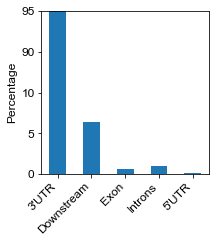

In [92]:
plt.figure(figsize=(3, 3))
plt.bar(x=np.arange(5), height=tot/sum(tot), width=.5)
plt.ylim(0, .2)
plt.xticks(
    np.arange(5), 
    ['3\'UTR', 'Downstream', 'Exon', 'Introns', '5\'UTR'],
    rotation=45,
    ha='right'
)
plt.yticks([0, 0.05, 0.1, 0.15, 0.2], [0, 5, 10, 90, 95])
plt.ylabel('Percentage')
plt.savefig('three_end_distribution.svg', bbox_inches='tight')

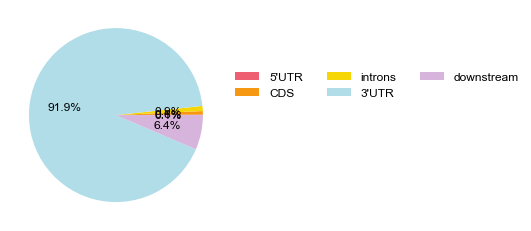

In [33]:
plt.pie(
    tot, autopct='%1.1f%%',
    colors=['#EF5F72', '#F79812', '#F7D606', '#B0DDE7', '#D7B4DB']
)

plt.legend(tot.index, bbox_to_anchor=(1, .25, 0.5, 0.5), frameon=False, ncol=3)
plt.savefig('3\'end_pct_cb2.svg', bbox_inches='tight')
plt.show()

In [ ]:
plt.legend?

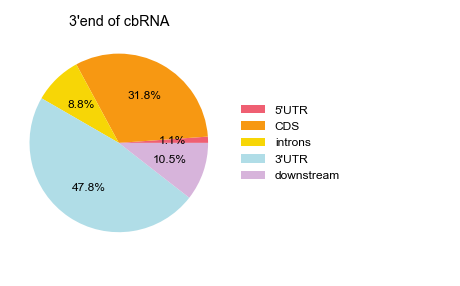

In [114]:
fig, ax = plt.subplots(1,2, figsize=(8, 5))

ax[0].set_title('3\'end of cbRNA')
pie = ax[0].pie(tot, 
        #labels=labels, 
        autopct='%1.1f%%', 
        colors=['#EF5F72', '#F79812', '#F7D606', '#B0DDE7', '#D7B4DB'])

# set legend
ax[1].legend(pie[0], tot.index, loc="center left", frameon=False,)
ax[1].spines['right'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)
ax[1].yaxis.set_major_locator(ticker.NullLocator())
ax[1].xaxis.set_major_locator(ticker.NullLocator())

plt.subplots_adjust(wspace=0)

**polt 3'end**

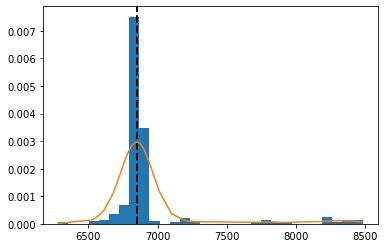

In [26]:
import scipy.stats as stats

gene_tpe = gene_tpe_list[1]
data = np.array(list(gene_tpe.elements()))
nparam_density = stats.kde.gaussian_kde(data)
x = np.array(list(gene_tpe.keys()))
nparam_density = nparam_density(x)
best = round(x[np.argsort(nparam_density)[-1]])
plt.axvline(best, ls='--', color='#000000', lw=2)
plt.hist(data, bins=30, density=True)
plt.plot(x, nparam_density)

In [63]:
best

6860

In [64]:
gene_tpe.most_common(1)

[(6854, 13)]